# One-Hot Fully-Connected Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [1]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [2]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import wandb

`wandb` log in:

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [4]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [5]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text decoder to be used (instantianted) in the notebook:

In [6]:
notebook_model = avm.LitOneHotFC
notebook_datamodule = avm.OneHotCharDataModule
# one_hot_decoding (ints_to_string) for one-hot (embedded text)
notebook_encoder = avm.one_hot_encoding 
notebook_decoder = avm.one_hot_decoding 
notebook_wandb_callback = avm.WandbTextCallback

Copy data to cwd for speed.

In [7]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [8]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

GPU
--------------------------------------------------
 Mon Dec 13 03:49:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [9]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_one_hot_fc


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [10]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [11]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [12]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [13]:
model_args_dic = {'seq_len': SEQ_LEN,
                  'tokens': tokens_df,
                  'fc_dims': [512, 256, 128, 64],
                  'nonlinearity': True
                  }
data_args_dic = {'seq_len': SEQ_LEN,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': num_processors,
                 'batch_size': 32,
                 'pin_memory': is_cuda_available,
                 'persistent_workers': True
                 }

Small test run.

In [14]:
small_data_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': .25}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, tokens_df)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dic)
print('Model layers:', small_model.layers)
small_preds, small_losses = small_model.scores_losses(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text:                                                                     a low energy neutrino factory for large $ \ theta _ { 13 } $
len: 128
source: False
text:                                 magnetic neutron scattering in solid oxygen and its applications to ultracold neutron production
len: 128
source: False
text:                                                                 properties of bose gas in a lattice model ( strong interaction )
len: 128
source: False
Model layers: ModuleList(
  (0): Linear(in_features=8832, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=1, bias=True)
)

preds shape: torch.Size([32])

actual loss: 0.6976076364517212

expected approx loss 0.6931471805599453


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [15]:
small_trainer = Trainer(gpus=-1,max_epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_4f2c596d-3e16-4211-bc95-3a4ac85fecd2.ckpt


Suggested lr: 0.0007585775750291835


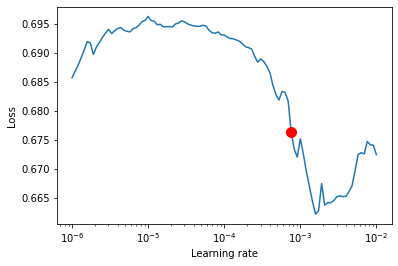

In [16]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
print(f'Suggested lr: {small_trainer_lr_finder.suggestion()}')

In [17]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | train_acc               | Accuracy         | 0     
1 | val_acc                 | Accuracy         | 0     
2 | test_acc                | Accuracy         | 0     
3 | train_auc_roc           | AUROC            | 0     
4 | val_auc_roc             | AUROC            | 0     
5 | test_auc_roc            | AUROC            | 0     
6 | train_average_precision | AveragePrecision | 0     
7 | val_average_precision   | AveragePrecision | 0     
8 | test_average_precision  | AveragePrecision | 0     
9 |

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyper_dic`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `fixed_hyper_dic` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [60]:
fixed_hyper_dic = {**model_args_dic, **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['early_terminate'] = {'type': 'hyperband',
                                    'min_iter': 3
                                   }
sweep_config['metric'] = {'name': 'best_val_loss',
                           'goal': 'minimize'
                           }
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'max': np.log(small_trainer_lr_finder.suggestion() * 10.).item(),
                                      'min': np.log(small_trainer_lr_finder.suggestion() / 10.).item()
                                      },                          
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyper_dic` for logging purposes.

In [61]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyper_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyper_dic['batch_size'] = 4096

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 16,
               }

# Merge trainer_dic into fixed_hyper_dic for logging purposes.
fixed_hyper_dic = {**fixed_hyper_dic, **trainer_dic}

def sweep_iteration():
    group_str = 'linear_models'
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**data_args_dic)
        config = wandb.config
        # Merge config into remaining parameters.
        config = {**fixed_hyper_dic, **config}
        model = notebook_model(**config)
        # Taking random samples from the validation set for callback visualization.
        val_sample_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': 512}})
        val_sample_module.setup()
        val_sample  = next(iter(val_sample_module.val_dataloader()))
        # Overwrite the random run names chosen by wandb.
        run.name = f"lr_{config['lr']}_layers_{'_'.join([str(size) for size in config['fc_dims']])}"
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[notebook_wandb_callback(val_sample=val_sample,
                                               decoder_fn=notebook_decoder,
                                               translation_data=tokens_df,
                                               labels=('arxiv', 'vixra')),
                       EarlyStopping(monitor='val_loss')
                       ],
            num_sanity_val_steps=-1,
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [62]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: y34fdvql
Sweep URL: https://wandb.ai/garrett361/balanced_title_one_hot_fc/sweeps/y34fdvql


In [63]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: 9j2nkr88 with config:
wandb: 	lr: 0.004643525274931863


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6936720609664917
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6936720609664917


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.5124198794364929
Validation Loss: 0.6577168703079224
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.5124198794364929
Validation Loss: 0.6577168703079224


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6550480723381042
Validation Loss: 0.6283544301986694
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6550480723381042
Validation Loss: 0.6283544301986694


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6594551205635071
Validation Loss: 0.6119329333305359
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6594551205635071
Validation Loss: 0.6119329333305359


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6501068472862244
Validation Loss: 0.6012628078460693


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6975160241127014
Validation Loss: 0.5941076278686523
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6975160241127014
Validation Loss: 0.5941076278686523


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.69017094373703
Validation Loss: 0.5825326442718506


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6981837749481201
Validation Loss: 0.5836012363433838


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▆▇▇█████
best_val_loss,█▅▄▃▂▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
global_step,▁▂▂▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▇▇██
train_auc_roc,▁▄▅▆▆▇▇██
train_average_precision,▁▄▅▆▆▇▇██
train_loss,█▅▄▄▃▂▂▂▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇██
val_acc,▁▆▇▆██▇█▇
val_auc_roc,▁▂▄▆▇█▇█▇


Run 9j2nkr88 errored: ValueError('signal only works in main thread')
wandb: ERROR Run 9j2nkr88 errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: ylshi36a with config:
wandb: 	lr: 0.0009757535514094324


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6933016777038574
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6933016777038574


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6534455418586731
Validation Loss: 0.6414878368377686
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6534455418586731
Validation Loss: 0.6414878368377686


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6522436141967773
Validation Loss: 0.6148084402084351


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6729433536529541
Validation Loss: 0.5925508737564087
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6729433536529541
Validation Loss: 0.5925508737564087


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6953792572021484
Validation Loss: 0.603959321975708


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6825587749481201
Validation Loss: 0.5859812498092651


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.7007211446762085
Validation Loss: 0.596698522567749


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▄▇▇███
best_val_loss,█▅▂▂▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
global_step,▁▂▃▄▄▅▆▇█
train_acc,▁▃▄▅▆▇██
train_auc_roc,▁▃▄▅▆▇██
train_average_precision,▁▃▄▅▆▇▇█
train_loss,█▇▆▅▄▃▂▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
val_acc,▁▁▄▇▅█▆▅
val_auc_roc,▁▃▆▇██▇█


Run ylshi36a errored: ValueError('signal only works in main thread')
wandb: ERROR Run ylshi36a errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: 9hmuy2in with config:
wandb: 	lr: 0.0003708239563334234


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.693619966506958
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.693619966506958


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6416933536529541
Validation Loss: 0.6295309066772461
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6416933536529541
Validation Loss: 0.6295309066772461


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6378205418586731
Validation Loss: 0.6123563051223755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6725427508354187
Validation Loss: 0.5913184285163879
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6725427508354187
Validation Loss: 0.5913184285163879


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.691773533821106
Validation Loss: 0.5834710597991943
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.691773533821106
Validation Loss: 0.5834710597991943


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6945779919624329
Validation Loss: 0.5811142921447754
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6945779919624329
Validation Loss: 0.5811142921447754


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6973824501037598
Validation Loss: 0.5799560546875
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6973824501037598
Validation Loss: 0.5799560546875


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.7045940160751343
Validation Loss: 0.5820152163505554


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.707932710647583
Validation Loss: 0.5866720080375671


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▄▆▇▇███
best_val_loss,█▆▃▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
global_step,▁▂▂▃▄▅▆▆▇█
train_acc,▁▅▅▆▇▇███
train_auc_roc,▁▃▄▅▆▇▇▇█
train_average_precision,▁▃▅▅▆▇▇▇█
train_loss,█▆▅▄▄▃▂▂▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇██
val_acc,▁▁▄▆▇▇█▆█
val_auc_roc,▁▄▆▇▇▇███


Run 9hmuy2in errored: ValueError('signal only works in main thread')
wandb: ERROR Run 9hmuy2in errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: jyj2kx9p with config:
wandb: 	lr: 0.0021251956628975965


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6961913108825684
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6961913108825684


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6550480723381042
Validation Loss: 0.6280524730682373
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6550480723381042
Validation Loss: 0.6280524730682373


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6247329115867615
Validation Loss: 0.6147547960281372


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6899038553237915
Validation Loss: 0.6070533990859985
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6899038553237915
Validation Loss: 0.6070533990859985


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6876335740089417
Validation Loss: 0.5836021900177002


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.7007211446762085
Validation Loss: 0.5948925614356995


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▆▆▆██
best_val_loss,█▆▅▁▁▁▁
epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
global_step,▁▂▃▄▅▆▇█
train_acc,▁▄▅▆▇▇█
train_auc_roc,▁▄▅▆▇██
train_average_precision,▁▄▆▆▇▇█
train_loss,█▆▅▄▃▂▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇██
val_acc,▄▁▇▇▆██
val_auc_roc,▁▄▆▇▇██


Run jyj2kx9p errored: ValueError('signal only works in main thread')
wandb: ERROR Run jyj2kx9p errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: jm52xnig with config:
wandb: 	lr: 0.002041429974933685


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6943245530128479
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6943245530128479


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6545138955116272
Validation Loss: 0.6247935891151428
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6545138955116272
Validation Loss: 0.6247935891151428


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6431623697280884
Validation Loss: 0.6139650940895081


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6657318472862244
Validation Loss: 0.5937705039978027
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6657318472862244
Validation Loss: 0.5937705039978027


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6845619678497314
Validation Loss: 0.586823582649231
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6845619678497314
Validation Loss: 0.586823582649231


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6957799196243286
Validation Loss: 0.6142650842666626


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▃▆▆██
best_val_loss,█▆▂▁▁▁▁
epoch,▁▁▂▂▃▃▅▅▆▆▇▇██
global_step,▁▂▃▄▅▆▇█
train_acc,▁▃▄▅▆▇█
train_auc_roc,▁▄▅▆▇▇█
train_average_precision,▁▄▅▆▇▇█
train_loss,█▆▅▄▃▂▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇██
val_acc,▃▂▄▇▆█▁
val_auc_roc,▁▃▆▇███


Run jm52xnig errored: ValueError('signal only works in main thread')
wandb: ERROR Run jm52xnig errored: ValueError('signal only works in main thread')


# Inspecting the Best Model

Load in the best model amongst all runs recorded in `wandb` for this notebook, as judged by `val_acc`.

In [18]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_val_acc' in run_json:
        notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df

,best_val_acc,config,name,wandb_path
0,0.707933,"{'lr': 0.0003708239563334234, 'fc_dims': [512,...",lr_0.0003708239563334234_layers_512_256_128_64,garrett361/balanced_title_one_hot_fc/9hmuy2in
1,0.707532,"{'lr': 0.0006568901076098428, 'fc_dims': [128,...",lr_0.0006568901076098428_layers_128_64,garrett361/balanced_title_one_hot_fc/qi4lx58u
2,0.705395,"{'lr': 0.0014400271725637068, 'fc_dims': [128,...",lr_0.0014400271725637068_layers_128_64,garrett361/balanced_title_one_hot_fc/qtx2pkvj
3,0.705128,"{'lr': 0.0007186788036313786, 'fc_dims': [128,...",lr_0.0007186788036313786_layers_128_64,garrett361/balanced_title_one_hot_fc/z5t70jx3
4,0.701923,"{'lr': 0.008611943794070421, 'fc_dims': [128, ...",lr_0.008611943794070421_layers_128_64,garrett361/balanced_title_one_hot_fc/t93kifmm
5,0.701122,"{'lr': 0.0004773785237612702, 'fc_dims': [128,...",lr_0.0004773785237612702_layers_128_64,garrett361/balanced_title_one_hot_fc/1urrqu3i
6,0.700721,"{'lr': 0.0021251956628975965, 'fc_dims': [512,...",lr_0.0021251956628975965_layers_512_256_128_64,garrett361/balanced_title_one_hot_fc/jyj2kx9p
7,0.700721,"{'lr': 0.0009757535514094324, 'fc_dims': [512,...",lr_0.0009757535514094324_layers_512_256_128_64,garrett361/balanced_title_one_hot_fc/ylshi36a
8,0.698184,"{'lr': 0.004643525274931863, 'fc_dims': [512, ...",lr_0.004643525274931863_layers_512_256_128_64,garrett361/balanced_title_one_hot_fc/9j2nkr88
9,0.695780,"{'lr': 0.002041429974933685, 'fc_dims': [512, ...",lr_0.002041429974933685_layers_512_256_128_64,garrett361/balanced_title_one_hot_fc/jm52xnig


Save the state dict for the best model locally and re-build the corresponding model.

In [19]:
best_model_wandb_path, best_model_config = notebook_runs_df.iloc[0].wandb_path, notebook_runs_df.iloc[0].config
# wandb also stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_model_config.items():
    if val == 'None':
        best_model_config[key] = None
# Also need to add the tokens arg back in, which isn't synced with wandb.
best_model_config['tokens'] = tokens_df
wandb.restore('model_best_val_acc.pt', run_path = best_model_wandb_path)
best_model = notebook_model(**best_model_config)
best_model.load_state_dict(torch.load('model_best_val_acc.pt'))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

Also write the best models (by `val_loss` and `val_acc`) to our final models folder:

In [20]:
wandb.restore('model_best_val_acc.onnx', run_path = best_model_wandb_path)
wandb.restore('model_best_val_loss.pt', run_path = best_model_wandb_path)
wandb.restore('model_best_val_loss.onnx', run_path = best_model_wandb_path)
!cp 'model_best_val_acc.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_acc.pt'}"
!cp 'model_best_val_acc.onnx' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_acc.onnx'}"
!cp 'model_best_val_loss.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_loss.pt'}"
!cp 'model_best_val_loss.onnx' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_loss.onnx'}"

Finally, examine the model's results on my own papers:

In [30]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


One-hot encode titles, stack into a tensor, and generate predictions:

In [31]:
goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, tokens_df, SEQ_LEN))], dim=0)
goon_papers_probs_t = best_model.inference(goon_papers_t)

According to this model, my titles are nearly just as likely to be from vixra as arxiv:

In [32]:
goon_papers_probs_t.mean()

tensor(0.4789)

In [33]:
goon_papers_df['vixra_prob'] = goon_papers_probs_t
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,source,vixra_prob
0,heavy fields and gravity,arxiv,0.933634
1,"quantum corrections to generic branes : dbi , nlsm , and more",arxiv,0.871633
2,massive gravity coupled to galileons is ghost - free,arxiv,0.743142
3,primordial non - gaussianity,arxiv,0.733818
4,galileons as wess - zumino terms,arxiv,0.711499
5,the effective theory of shift - symmetric cosmologies,arxiv,0.700932
6,gauged galileons from branes,arxiv,0.685744
7,partially massless fields during inflation,arxiv,0.661389
8,aspects of galileon non - renormalization,arxiv,0.482124
9,soft theorems for shift - symmetric cosmologies,arxiv,0.471275
